## Import Libraries 

In [73]:
# import libraries
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import preprocessing
from itertools import islice
import seaborn as sns
import six
import sys
sys.modules['sklearn.externals.six'] = six

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import scipy.stats as stat
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import tree

In [74]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api

#### Load data

In [75]:
data_frame = pd.read_csv("../Data/ADSmartdata.csv") # load data

#### Drop observations where users didn't respond to the questionaire

In [76]:
drop_mask = data_frame.query('yes==0 and no==0') # drop columns where yes and no are both 0
data_frame=data_frame.drop(drop_mask.index)

In [77]:
data_frame.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1


In [78]:
data_frame.isna().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

## Logistic Regression Wrapper Class

Custom Logistic Regression model with p-value calculation capability

In [79]:
# custom logistic regression wrapper that accepts a Linear Regressor and adds p-value calculator 

class LogisticReg:
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = LogisticRegression(*args,**kwargs)#,**args)
    

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) 
        Cramer_Rao = np.linalg.inv(F_ij) 
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates 
        p_values = [stat.norm.sf(abs(x)) for x in z_scores]
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij
        return self.model,p_values

### Function for creating an awareness column

In [80]:
# crate an awareness column to the dataframe
def label_awareness (row):
    if row['yes'] == 1 :
         return '1'
    if row['no'] == 1 :
        return '0'
def calculate_metrics(y_test, y_preds):
    
    accuracy = accuracy_score(y_test, y_preds)
    return accuracy



## Function for plotting confusion matrix

In [81]:
# plot confusion metrics of a model. It accepts predictions and actual values for the target variable
def draw_confusion_metrics(y_test, y_preds):
    cnf_matrix = metrics.confusion_matrix(y_test, y_preds)
    ax=sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

## Function for getting the best parameters for a model

In [82]:
def get_best_model(classifier, params):
    best_avg_score = 0
    best_param = ''
    best_model = None
    fold_num=1
    p_value = []
    # create 5 folds
    kf = KFold(n_splits = 5)
    for param in params:
        p_values = []
        scores=[]
        randomIter = kf.split(x_train)
        i=0
        while i<5:
            train_idx, validation_idx = next(randomIter)
            x_validation = x_train.iloc[validation_idx]
            x_training = x_train.iloc[train_idx]
            y_validation = y_train.iloc[validation_idx]
            y_training = y_train.iloc[train_idx]
            x_training_refined = x_training.drop(columns=['auction_id','yes','no','date'], axis=1)
            x_validation_refined = x_validation.drop(columns=['auction_id','yes','no','date'], axis=1)
            if(classifier == 'Decision Tree'):
                clf = DecisionTreeClassifier(**param)
            if(classifier == 'XGBoost'):
                clf = XGBClassifier(**param)
            if(classifier == 'Logistic'):
                clf  = LogisticReg(solver = param)
            
            
            if(classifier == 'Logistic'):
                clf,p_values = clf.fit(x_training_refined.astype(float),y_training.astype(float))
            else:
                clf = clf.fit(x_training_refined.astype(float),y_training.astype(float))
            y_preds = clf.predict(x_validation_refined)
            score = accuracy_score(y_validation.astype(float), y_preds)
            scores.append(score)
            i+=1
        avg = sum(scores)/len(scores)
        print('Fold',fold_num,'average',avg)
        if(avg>best_avg_score):
            best_avg_score = avg
            best_param = param
            best_model = clf
            p_value = p_values
        fold_num+=1
    
    return best_model, best_param, best_avg_score,p_value


In [83]:
data_frame['awareness'] = data_frame.apply (lambda row: label_awareness(row), axis=1) # apply awareness to each row
data_frame.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,awareness
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1,0
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0,1
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0,1
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1,0


### Change categorical variables to numerical value

In [84]:
# change categorical variables to numerical value
lb = LabelEncoder()
data_frame['experiment'] = lb.fit_transform(data_frame['experiment'])
data_frame['browser'] = lb.fit_transform(data_frame['browser'])
data_frame['device_make'] = lb.fit_transform(data_frame['device_make'])

### Split the dataset to training(90%) and test(10%)
The training set will be further divided to training and validation

In [85]:
# separate features and target columns
data_x = data_frame.loc[:, data_frame.columns != 'awareness']
data_y = data_frame['awareness']

# split the dataset to training and test sets
train_ratio = 0.90
test_ratio = 0.10
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=1 - train_ratio)

# Logistic Regression

In [86]:
from sklearn.preprocessing import MinMaxScaler

solver_params=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

best_model = get_best_model('Logistic', solver_params)
print('Best score: ' , best_model[1],'--->', best_model[2])

Fold 1 average 0.5312620115310698
Fold 2 average 0.5267977258167842
Fold 3 average 0.527714606021781
Fold 4 average 0.5312820307495196
Fold 5 average 0.5330797565663038
Best score:  saga ---> 0.5330797565663038


As we can observe from the above cell, the best parameters for the logistic regression model were found on fold 5. Fold 5 used the saga solver. 

## Statistical Significance of Features

Plot p-values and compare it to significance level of 0.05  to check statistical significance of each cooficient

,Feature,Coffecient,p_value
0,Experiment,0.063005,0.325336
2,Device Make,0.002820,0.200184
4,Browser,-0.064777,0.084070
3,Platform Os,-0.076314,0.012377
1,Hour,0.033159,0.002706


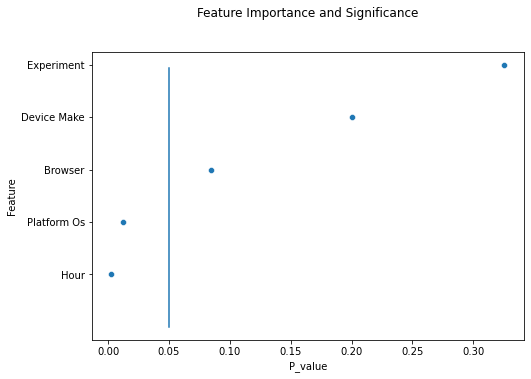

In [87]:
df_pvalue = pd.DataFrame(best_model[3]).reset_index().rename(columns={'index':'Terms', 0:'p_value'})
df_pvalue['Feature']=['Experiment','Hour','Device Make','Platform Os','Browser']

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
df_pvalue['Coffecient']=list(best_model[0].coef_[0])
df_pvalue= df_pvalue.sort_values('p_value',ascending=False)

ax = sns.scatterplot(x='p_value', y='Feature', data=df_pvalue)
plt.plot([0.05,0.05], [0.05,5])
plt.title('Feature Importance and Significance', y=1.1)
plt.ylabel('Feature')
plt.xlabel('P_value')

df_pvalue[['Feature','Coffecient','p_value']]

As we can see from the above cell, platform_os and hour are the only features with a p_value less than 0.05. The coefficient of platform os is 0.0486 which shows its level of negative impact on determining the awareness level of users.

(LogisticRegression(solver='saga'), 'saga', 0.5330797565663038, [0.3253364142811029, 0.0027055759676887265, 0.20018429776121827, 0.012376947480887827, 0.08406962626773268])


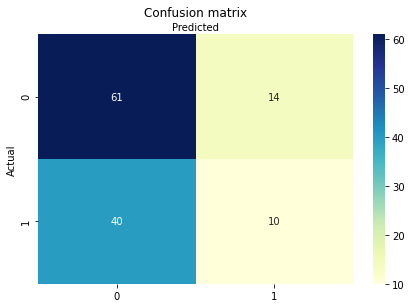

In [88]:

print(best_model)
x_test_refined = x_test.drop(columns=['auction_id','yes','no','date'], axis=1)
y_preds = best_model[0].predict(x_test_refined.astype(float))
draw_confusion_metrics(y_test.astype(float) , y_preds)

The above confusion matrix shows the model ihas 41 False Negatives and 12 True Positives.

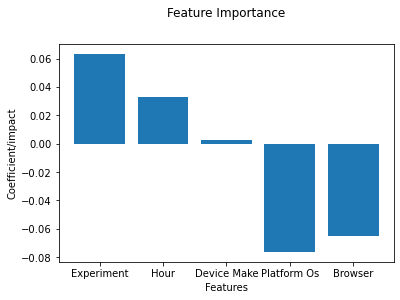

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [89]:
# plot feature importance
importance = best_model[0].coef_[0]
plt.figure()
plt.title('Feature Importance', y=1.1)
plt.ylabel('Coefficient/impact')
plt.xlabel('Features')
plt.bar(['Experiment','Hour','Device Make','Platform Os','Browser'], importance)
plt.show()
plt.figure()


# Dicision Tree Classifier

Create five folds and split each fold to validation,training And testing . Each fold uses a different set of parameters to find out which one works best.

In [90]:
params=[{'max_depth':3,'min_samples_split':2},{'max_depth':3,'min_samples_split':2},{'max_depth':3,'min_samples_split':2},
               {'max_depth':3,'min_samples_split':2},{'max_depth':3,'min_samples_split':2}]

best_model = get_best_model('Decision Tree', params)

print('Best score: ' , best_model[1],'--->', best_model[2])


Fold 1 average 0.5375840807174888
Fold 2 average 0.5375840807174888
Fold 3 average 0.5375840807174888
Fold 4 average 0.5375840807174888
Fold 5 average 0.5375840807174888
Best score:  {'max_depth': 3, 'min_samples_split': 2} ---> 0.5375840807174888


## Feature Importance (Decision Trees)

<AxesSubplot:xlabel='Feature'>

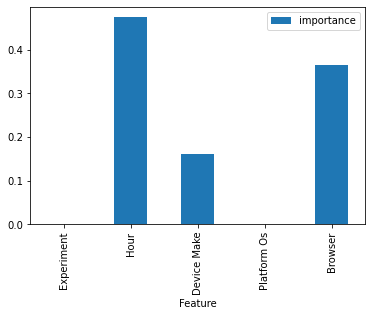

In [91]:

df_importance = pd.DataFrame({'importance': best_model[0].feature_importances_})
df_importance['Feature']=['Experiment','Hour','Device Make','Platform Os','Browser']
df_importance = df_importance.set_index('Feature')
df_importance.plot(kind='bar')

The decision tree model believes the device_make feature is the most important.

## Visualizing the decision tree

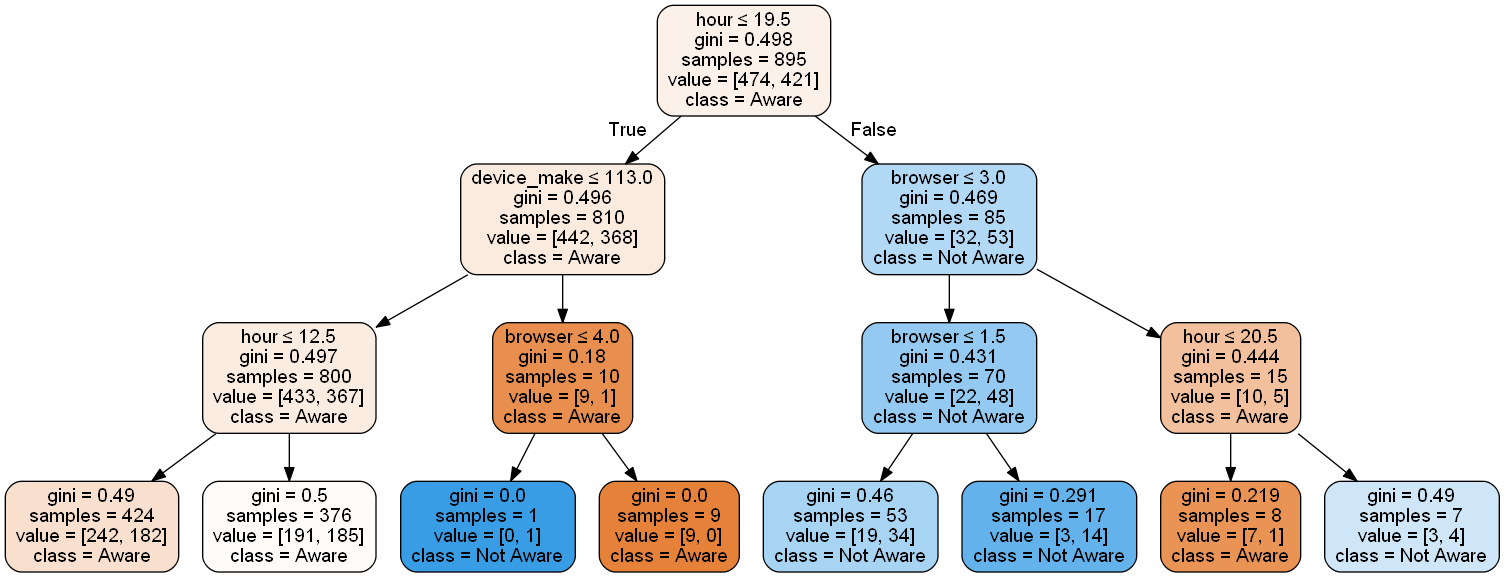

In [96]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Abreham/miniconda3/Library/bin/graphviz'
#Note to modify your path
dot_data = StringIO()
x_test_refined = x_test.drop(columns=['auction_id','yes','no','date'], axis=1)

dot_data = tree.export_graphviz(best_model[0], out_file="resume.dot",
feature_names=list(x_test_refined),class_names=['Aware','Not Aware'],
filled=True, rounded=True, special_characters=True, leaves_parallel=False)
graph = pydotplus.graphviz.graph_from_dot_file("resume.dot")
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The above plot visualizes the dicisions made by the model. It is visible that if hour> 19.5 ( late in to the night ), people's level of awareness decreases.

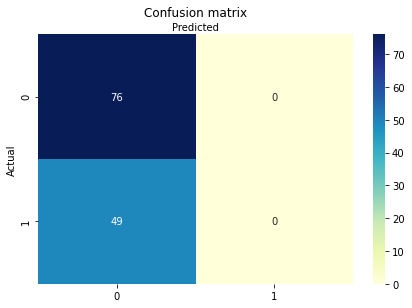

In [26]:
y_preds = best_model[0].predict(x_test_refined.astype(float))

draw_confusion_metrics(y_test.astype(float), y_preds)

The above confusion matrix shows the Desicion tree model resulted in 23 False Negatives and 46 False positives

# XG Boost

Create five folds and split each fold to validation and training with a proportion of 20%,80% respectively. Each fold uses a different set of parameters to find out which one works best.

In [27]:
params=[{'random_state':1,'learning_rate':0.02},{'random_state':2,'learning_rate':0.01},{'random_state':3,'learning_rate':0.02},
       {'random_state':3,'learning_rate':0.05},{'random_state':2,'learning_rate':0.02}]
best_model = get_best_model('XGBoost', params)

print('Best score: ' , best_model[1],'--->', best_model[2])

[09:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

As we can see from above cell, the 5th fold with random state of 1 and learning rate of 0.02 is the best performer.

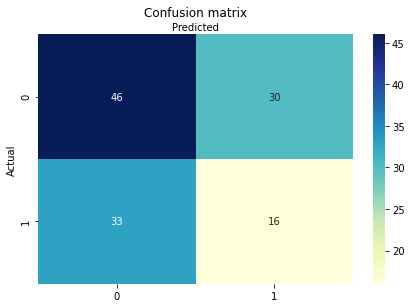

In [28]:
x_test_refined = x_test.drop(columns=['auction_id','yes','no','date'], axis=1)
y_preds = best_model[0].predict(x_test_refined.astype(float))
draw_confusion_metrics(y_test.astype(float), y_preds)

The above confusion matrix shows the model came up with 41 false negatives and 19 false positives.

## Feature Importance (XGBoost)

<AxesSubplot:xlabel='Feature'>

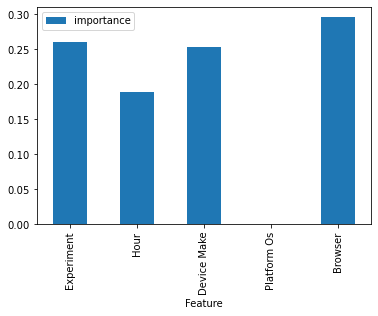

In [29]:

df_importance = pd.DataFrame({'importance': best_model[0].feature_importances_})
df_importance['Feature']=['Experiment','Hour','Device Make','Platform Os','Browser']
df_importance = df_importance.set_index('Feature')
df_importance.plot(kind='bar')

XGBoost also predicts hour is the most important feature.

# Observations


* As shown in the above plot all features except platform os are relevant.
* Unlike statistical inference, Machine Learning algorithms enable us to model complex systems that include all of the ongoing events, user features, and more. 
* An attractive benefit to Machine Learning is that we can combine multiple approaches to gain insights.

* Cross-validation is a technique to evaluate predictive models by dividing the original sample into a training set to train the model, and a validation set to evaluate it.
* I tried changing different parameters of each model for each fold to find out which model is performing better.

## conclusion

*  We discovered that the system is impacted by hours in logistic regression.
* Magnitude and direction of impact- We discovered the impact each features had on the awareness of the users and wether it is positive or not